In [1]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import os

import sys
sys.path.insert(1,'../data_utils/')
from Sample import Sample 
from HiCDataset import HiCDataset
from HiCMap import HiCMap
from ConfigDataset import ConfigDataset
from OrigamiTransform import OrigamiTransform
origami_transform = OrigamiTransform()
sys.path.insert(2,'../diffusion/')
from classifier_free_guidance_greg import Unet, GaussianDiffusion

INFO:torch.distributed.nn.jit.instantiator:Created a temporary directory at /state/partition1/slurm_tmp/24912152.0.0/tmpldcoumj0
INFO:torch.distributed.nn.jit.instantiator:Writing /state/partition1/slurm_tmp/24912152.0.0/tmpldcoumj0/_remote_module_non_scriptable.py
2024-01-31 15:31:02.018985: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
chroms = ['1','X']
region_idx = None #None if no restriction
nbeads = 64
resolution = 20_000
embeddings_nbeads = 65 
sample_directory = '/home/gridsan/gschuette/refining_scHiC/revamp_with_zhuohan/data/samples/origami_64_resnet_like/'
'''
cond_scales = 2.#5.#.4 #[k/10 for k in range(10)]#[0.5,1.,2.,3.,4.,5.]
rescaled_phis = 10#5.#.4 #[k/10 for k in range(10)]
milestones = 120#240 
'''
'''
cond_scales = .9
rescaled_phis = .9
milestones = 120
'''
cond_scales = .4
rescaled_phis = .4
milestones = 120

r_c = 1.6
sigma = 6

In [3]:
config_ds = ConfigDataset(
    filepath='../../data/processed_data.hdf5',
    segment_length=nbeads,
    allow_overlap=True,
    chroms = chroms,
    replicates=[1]
)

In [4]:
exp_hic = HiCDataset()

In [5]:
#emb_fp = lambda chrom: f'/home/gridsan/gschuette/refining_scHiC/revamp_with_zhuohan/data/embeddings/chrom_{chrom}.tar.gz'
emb_fp = lambda chrom: f'/home/gridsan/gschuette/refining_scHiC/revamp_with_zhuohan/data/embeddings_{embeddings_nbeads}/chrom_{chrom}.tar.gz'
embeddings_dict = {}
for chrom in chroms: 
    embeddings_dict[chrom] = pd.read_pickle(emb_fp(chrom))

In [6]:
def get_tan_coords(region_idx=region_idx,embeddings=embeddings_dict[chroms[0]]):
    _,chrom,start_idx = embeddings.index[region_idx]
    _,coords = config_ds.fetch_specific_coords(chrom,start_idx)
    return coords

In [7]:
def remove_diagonal(x):
    s = x.shape[-1]
    i,j = torch.triu_indices(s,s,1)
    x2 = torch.empty(*x.shape[:-2],s-1,s-1,dtype=x.dtype,device=x.device)
    x2[...,i,j-1] = x[...,i,j]
    x2[...,j-1,i] = x[...,j,i]
    return x2

def add_diagonal(x,diag_value=0):
    s = x.shape[-1]
    i,j = torch.triu_indices(s,s,0)
    x2 = torch.empty(*x.shape[:-2],s+1,s+1,dtype=x.dtype,device=x.device)
    x2[...,i,j+1] = x[...,i,j]
    x2[...,j+1,i] = x[...,j,i] 
    i = torch.arange(s+1)
    x2[...,i,i] = diag_value
    return x2
    
def get_tan_sample(
    region_idx,
    chrom,
    embeddings={chrom:embeddings_dict[chrom] for chrom in chroms}
):
    coords = get_tan_coords(region_idx,embeddings[chrom])
    dists = torch.cdist(coords,coords)
    return Sample(data=remove_diagonal(dists))

In [8]:
def get_exp_map(
    region_idx,
    chrom,
    exp_hic=exp_hic,
    emb_idx={chrom:embeddings_dict[chrom].index for chrom in chroms},
    interp_nans=True,
    region_length=nbeads*20_000
):

    # Get the region information from the embedding index used during sample generation
    region_length1, chrom, start = emb_idx[chrom][region_idx]
    region_length = region_length1 if region_length is None else region_length
    stop = start + region_length
    
    return exp_hic.fetch(chrom=chrom,start=start,stop=stop,interp_nans=interp_nans)

In [9]:
#_,chrom_,si = embeddings_dict[chroms[0]].index[region_idx]
#assert chrom == chrom_ 
def compare_to_exp(gen_map,region_index=region_idx):
    exp_map = get_exp_map(region_index)
    pcc = gen_map.pcc(exp_map)
    fig,ax,im,cbar = exp_map.plot_with(gen_map)
    ax.set_title(f'Chrom {chrom}, {si}-{si+nbeads*20_000}\nPCC: {pcc}')
    return fig, ax, im, cbar

In [10]:
def load_sample(
    filepath = None,
    directory=sample_directory, #'/home/gridsan/gschuette/refining_scHiC/revamp_with_zhuohan/code/diffusion_v1/sampling_small/',
    region_idx=0,
    cond_scale=1.,
    rescaled_phi=.7,
    milestone=69,
    chrom=1
):

    if filepath is None: 
        if directory != '' and directory[-1] != '/':
            directory+= '/'
        
        fps = [ # placed in order of preference, per the next loop 
            f'{directory}sample_{region_idx}_{cond_scale}_{rescaled_phi}_{milestone}_{chrom}.pt',
            f'{directory}sample_{region_idx}_{cond_scale}_{rescaled_phi}_{milestone}_{chrom}.pkl',
            f'{directory}sample_{region_idx}_{int(cond_scale)}_{int(10*rescaled_phi)}_{milestone}_{chrom}.pt',
            f'{directory}sample_{region_idx}_{int(cond_scale)}_{int(10*rescaled_phi)}_{milestone}_{chrom}.pkl'
        ]
        for fp in fps: 
            if os.path.exists(fp):
                break
    else: 
        fp = filepath 

    if fp.split('.')[-1] == 'pkl':
        data = pd.read_pickle(fp).unflatten()
    else:
        data = torch.load(fp)
        if data.shape[-3] == 2:
            data = origami_transform.inverse(data)
            data = remove_diagonal(data)
    if len(data.shape) == 2: 
        data = data.unsqueeze(0)
    #if len(data.shape) == 3:
    #    data = data.unsqueeze(1)

    return Sample(data=data)
    #return pd.read_pickle(fp)
    #return Sample(data=pd.read_pickle(fp).batch)
    


In [11]:
def tanh_map(sample,r_c,sigma):
    '''
    Avoids using the distance correction approach
    '''
    if sample.normalized: 
        sample.unnormalize_()
    r = sample.unflatten()

    mask = r < r_c 
    r[mask] = .5*( 1 + torch.tanh( sigma*( r_c - r[mask] ) ) )
    mask^= True
    r[mask] = .5 * ( r_c / r[mask] )**4
    
    return HiCMap(r.mean(0).squeeze(),includes_self_interaction=False)

def thresh_map(sample,r_c):
    '''
    Avoid using distance correction approach
    '''
    if sample.normalized: 
        sample.unnormalize_()
    r = sample.unflatten()

    below_thresh = (r < r_c).float()
    below_thresh[r.isnan()] = torch.nan
    
    return HiCMap(torch.nanmean(below_thresh,dim=0).squeeze(),includes_self_interaction=False)
    

In [12]:
def nanstd(x,dim=None):
    return ( torch.nanmean(x**2,dim=dim) - torch.nanmean(x,dim=dim)**2 ).sqrt()
    
def get_std(sample):
    x = sample.unflatten().squeeze()
    x[~x.isfinite()] = torch.nan
    return nanstd(x,dim=0)

def get_mean(sample):
    x = sample.unflatten().squeeze()
    x[~x.isfinite()] = torch.nan
    return torch.nanmean(x,dim=0)

def plot_stats_2d(mean_gen,fig=None,ax=None,distances=True):

    if ax is None and fig is None:
        fig = plt.figure()
    if ax is None:
        ax = fig.add_subplot(111)
        
    im = ax.matshow(mean_gen.prob_map.numpy(),cmap='Greys')
    ax.set_xticks([])
    ax.set_yticks([])
    cbar = fig.colorbar(
        im,
        label = 'Distance' if distances else 'Distance Standard Deviation',
        ax=ax
    )
    
    return fig, ax, im, cbar

def plot_stats_1d(mean_gen,fig=None,ax=None,distances=True):

    x = mean_gen.prob_map.numpy()
    i,j = torch.triu_indices(x.shape[-1],x.shape[-1],1)

    x,y = x[i,j], x[j,i]

    v = [max(x.min(),y.min()),min(x.max(),y.max())]

    if ax is None and fig is None:
        fig = plt.figure()
    if ax is None:
        ax = fig.add_subplot(111)
    ax.plot(x,y,'.')
    ax.plot(v,v)
    if distances:
        ax.set_xlabel('Mean Distances: Tan Dataset')
        ax.set_ylabel('Mean Distances: Generated Data')
    else:
        ax.set_xlabel('Distance Standard Deviation: Tan Dataset')
        ax.set_ylabel('Distance Standard Deviation: Generated Data')
    
    return fig,ax

def plot_stats(sample,sample_tan):

    std_tan = HiCMap(sample_tan.unflatten().std(0).squeeze())
    mean_tan = HiCMap(sample_tan.unflatten().mean(0).squeeze())

    std_gen = HiCMap(get_std(sample))
    pcc_std = std_gen.pcc(std_tan)
    std_gen.replace_lower_triangle(std_tan)
    std_gen.T_()

    mean_gen = HiCMap(get_mean(sample))
    pcc_mean = mean_gen.pcc(mean_tan)
    mean_gen.replace_lower_triangle(mean_tan)
    mean_gen.T_()

    ########
    # plots
    fig = plt.figure(figsize=(10,7.5))
    ax1 = fig.add_subplot(221)
    plot_stats_2d(mean_gen,fig=fig,ax=ax1,distances=True)
    ax1.set_title(f'PCC: {pcc_mean}')
    ax2 = fig.add_subplot(222)
    plot_stats_1d(mean_gen,fig=fig,ax=ax2,distances=True)
    ax3 = fig.add_subplot(223)
    plot_stats_2d(std_gen,fig=fig,ax=ax3,distances=False)
    ax3.set_title(f'PCC: {pcc_std}')
    ax4 = fig.add_subplot(224)
    plot_stats_1d(std_gen,fig=fig,ax=ax4,distances=False)

    return fig, ax1, ax2, ax3, ax4

In [13]:
def to_list(object):
    return object if type(object) == list else [object]

def parse_filename(filename):
    filename = filename.split('/')[-1]  # remove directory path
    components = filename.split('_')
    region_idx = int(components[1])
    cond_scale = float(components[2]) if '.' in components[2] else int(components[2])
    rescaled_phi = float(components[3]) if '.' in components[3] else int(components[3])
    milestone = int(components[4])
    chrom = components[5].split('.')[0]

    return region_idx, cond_scale, rescaled_phi, milestone, chrom

def is_valid(
    filename,
    region_idx,
    cond_scale,
    rescaled_phi,
    milestone,
    chrom
):

    try:
        ri, cs, rp, ms, ch = parse_filename(filename) 
    except:
        return False, (None, None, None, None, None)
    
    for desired,actual in [(region_idx,ri),(cond_scale,cs),
                         (rescaled_phi,rp),(milestone,ms),(chrom,ch)]:
        if desired is not None and actual not in to_list(desired):
            return False, (ri, cs, rp, ms, ch)
    
    return True, (ri, cs, rp, ms, ch)
    
def get_all_sample_types(
    sample_directory=sample_directory,
    *,
    region_idx=None,
    cond_scale=None,
    rescaled_phi=None,
    milestone=None,
    chrom = None
):
    samples = os.listdir(sample_directory)

    to_process = pd.DataFrame({
        'region_idx':[],
        'cond_scale':[],
        'rescaled_phi':[],
        'milestone':[],
        'chrom':[],
    })
    
    for f in samples:
        valid, properties = is_valid(f,region_idx,cond_scale,rescaled_phi,milestone,chrom) 
        if valid: 
            to_process.loc[len(to_process)] = properties

    to_process.sort_values(
        ['milestone','chrom','region_idx','cond_scale','rescaled_phi'], # sorts in this order
        inplace=True,
        ignore_index=True,
    )

    return [*to_process.itertuples(index=False,name=None)]

    
    

Get the set of valid files

In [14]:
sample_details = get_all_sample_types(sample_directory,cond_scale=cond_scales,rescaled_phi=rescaled_phis,milestone=milestones,chrom=chroms)
len(sample_details)

26

Load the generated samples

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

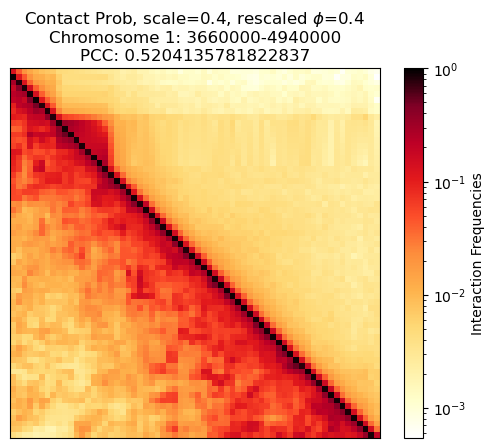

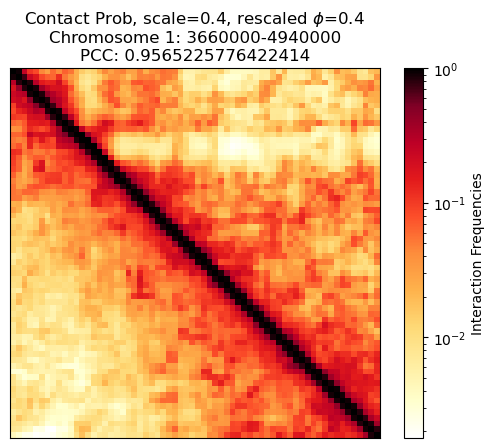

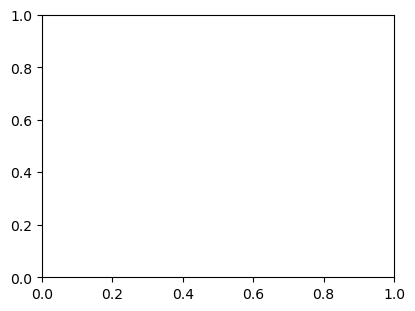

In [15]:
last_ri = None
last_chrom = None
for region_idx, cond_scale, rescaled_phi, milestone, chrom in sample_details: 
    
    # Load the sample 
    sample = load_sample(
        region_idx=region_idx,
        cond_scale=cond_scale,
        rescaled_phi=rescaled_phi,
        milestone=milestone,
        chrom = chrom
    )

    start_idx = embeddings_dict[chrom].index[region_idx][-1]
    stop_idx = start_idx + nbeads * resolution
    # Get the contact probability map 
    gen_probs_uncorrected = tanh_map(sample,r_c,sigma)
    #gen_probs_uncorrected = thresh_map(sample,r_c)

    #####
    # Plot it against experimental probabilities
    if region_idx != last_ri or chrom != last_chrom:
        exp_probs = get_exp_map(region_idx,chrom)
    _,ax,_,_ = exp_probs.plot_with(gen_probs_uncorrected)
    ax.set_title(
        f'Contact Prob, scale={cond_scale}, rescaled $\\phi$={rescaled_phi}\n'+\
        f'Chromosome {chrom}: {start_idx}-{stop_idx}\n'+\
        f'PCC: {exp_probs.pcc(gen_probs_uncorrected)}'
    )

    #####
    # Plot it against Longzhi Tan-derived data

    # Load the relevant tan data 
    if region_idx != last_ri or chrom != last_chrom:
        sample_tan = get_tan_sample(region_idx,chrom)
        tan_map = tanh_map(sample_tan,r_c,sigma)

    # Probability map comparison
    _,ax,_,_ = tan_map.plot_with(gen_probs_uncorrected)
    ax.set_title(
        f'Contact Prob, scale={cond_scale}, rescaled $\\phi$={rescaled_phi}\n'+\
        f'Chromosome {chrom}: {start_idx}-{stop_idx}\n'+\
        f'PCC: {tan_map.pcc(gen_probs_uncorrected)}'
    )

    # Compare the generated distance statistics to the Longzhi Tan dataset's statistics
    fig, *_ = plot_stats(sample,sample_tan)
    fig.suptitle(
        f'Statistics Comparison, scale={cond_scale}, rescaled $\\phi$={rescaled_phi}\n'+\
        f'Chromosome {chrom}: {start_idx}-{stop_idx}'
    )
    
    # Update for next part of loop
    last_chrom = chrom
    last_ri = region_idx

Guidance .9, rescaling phi .9

In [ ]:
sample_details = get_all_sample_types(sample_directory,cond_scale=.9,rescaled_phi=.9,milestone=milestones,chrom=chroms)

last_ri = None
last_chrom = None
for region_idx, cond_scale, rescaled_phi, milestone, chrom in sample_details: 
    
    # Load the sample 
    sample = load_sample(
        region_idx=region_idx,
        cond_scale=cond_scale,
        rescaled_phi=rescaled_phi,
        milestone=milestone,
        chrom = chrom
    )

    start_idx = embeddings_dict[chrom].index[region_idx][-1]
    stop_idx = start_idx + nbeads * resolution
    # Get the contact probability map 
    gen_probs_uncorrected = tanh_map(sample,r_c,sigma)
    #gen_probs_uncorrected = thresh_map(sample,r_c)

    #####
    # Plot it against experimental probabilities
    if region_idx != last_ri or chrom != last_chrom:
        exp_probs = get_exp_map(region_idx,chrom)
    _,ax,_,_ = exp_probs.plot_with(gen_probs_uncorrected)
    ax.set_title(
        f'Contact Prob, scale={cond_scale}, rescaled $\\phi$={rescaled_phi}\n'+\
        f'Chromosome {chrom}: {start_idx}-{stop_idx}\n'+\
        f'PCC: {exp_probs.pcc(gen_probs_uncorrected)}'
    )

    #####
    # Plot it against Longzhi Tan-derived data

    # Load the relevant tan data 
    if region_idx != last_ri or chrom != last_chrom:
        sample_tan = get_tan_sample(region_idx,chrom)
        tan_map = tanh_map(sample_tan,r_c,sigma)

    # Probability map comparison
    _,ax,_,_ = tan_map.plot_with(gen_probs_uncorrected)
    ax.set_title(
        f'Contact Prob, scale={cond_scale}, rescaled $\\phi$={rescaled_phi}\n'+\
        f'Chromosome {chrom}: {start_idx}-{stop_idx}\n'+\
        f'PCC: {tan_map.pcc(gen_probs_uncorrected)}'
    )

    # Compare the generated distance statistics to the Longzhi Tan dataset's statistics
    fig, *_ = plot_stats(sample,sample_tan)
    fig.suptitle(
        f'Statistics Comparison, scale={cond_scale}, rescaled $\\phi$={rescaled_phi}\n'+\
        f'Chromosome {chrom}: {start_idx}-{stop_idx}'
    )
    
    # Update for next part of loop
    last_chrom = chrom
    last_ri = region_idx